In [1]:
import numpy as np
import librosa
import librosa.display
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd

# My modules
import paths

In [2]:
music_path = os.path.join(os.environ['MUSIC_PATH'])

y, sr = librosa.load(music_path, sr=None) # sr=None preserves the original sample rate
print (sr)
print (len(y))

16000
185856


In [3]:
ipd.Audio(y, rate=sr)

(1025, 581)


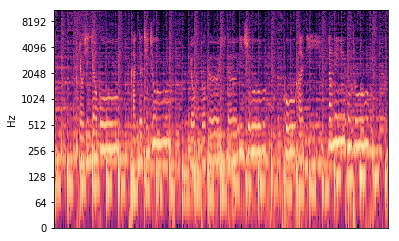

In [4]:
S = librosa.stft(y, win_length=int(40*sr/1000), hop_length=int(20*sr/1000))
D = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(D, y_axis='log')

print (D.shape)

(579,)


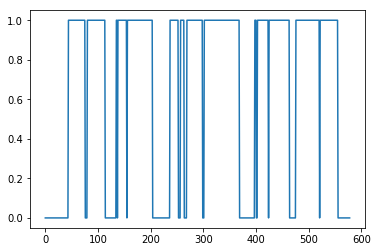

In [100]:
vocal_path = os.path.join(os.environ['VOCAL_PATH'])

label = pd.read_csv(vocal_path, index_col=None, header=None)
label  = np.array(label).reshape((label.shape[0],)).astype('bool')

print (label.shape)
plt.plot(label)
plt.show()

# Calculate the energy for each frame using a square window 'w'
Formula: $\sum_m |x(m)w(m-n)|^2 $

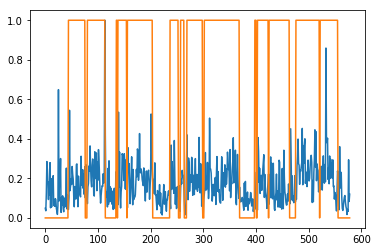

In [99]:
# w(x) = 1, for all x

hop  = 20 #milisseconds
size = 40 #milisseconds

energy = []

# Each frame has 40ms, it means, 40*16 samples
for idx in range(label.shape[0]):
    start = int(hop*sr/1000*idx)
    frame = y[start:start+size]

    energy.append(np.sum([np.abs(x) for x in frame]))
    
# Normalize energy
energy /= np.max(energy)

plt.plot(energy)
plt.plot(label)
plt.show()

# Evaluation

In [7]:
import mir_eval

In [8]:
# Bug on MIR_EVAL ** The parameters' order are wrong
R, FA = mir_eval.melody.voicing_measures(np.array(label), np.array(output)) 
print ("Recall", R, "False Alarme", FA) ### Strange :/

Recall 0.922279792746 False Alarme 0.922279792746


In [97]:
def find_threshold(ref_values, energy):
    
    last_acc = 0 # Start accuracy
    steps = 101
    
    R, P, Acc, F1, FA = [],[],[],[],[]
    
    for threshold in np.linspace(0, 1, steps):
        est_values = []
        for e in energy:
            if e >= threshold:
                est_values.append(1)
            else:
                est_values.append(0)
        
        est_values = np.array(est_values).astype('bool')
        
        TP = (ref_values*est_values).sum()
        FP = ((ref_values == 0)*est_values).sum()
        FN = (ref_values*(est_values == 0)).sum()
        TN = ((ref_values == 0)*(est_values == 0)).sum()
        
        R.append(TP/(TP+FN))
        P.append(TP/(TP+FP))
        
        Acc.append((TP+TN)/(TP+TN+FP+FN))
        F1.append(2*P[-1]*R[-1]/(P[-1]+R[-1]))
        FA.append(FP/(FP+TN))
        
        if last_acc <= Acc[-1]:
            last_acc = Acc[-1]
            best = threshold
#         else:
#             print ("Recall", R[-1])
#             print ("P", P[-1])
#             print ("F1", F1[-1])
#             print ("FA", FA[-1])
         
    plt.figure(figsize=(12,8))
    plt.plot(R, label='R')
    plt.plot(P, label='P')
    plt.plot(Acc, label='Acc')
    plt.plot(F1, label='F1')
    plt.plot(FA, label='FA')
    # Place a legend to the right of this smaller subplot.
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
        
    return best

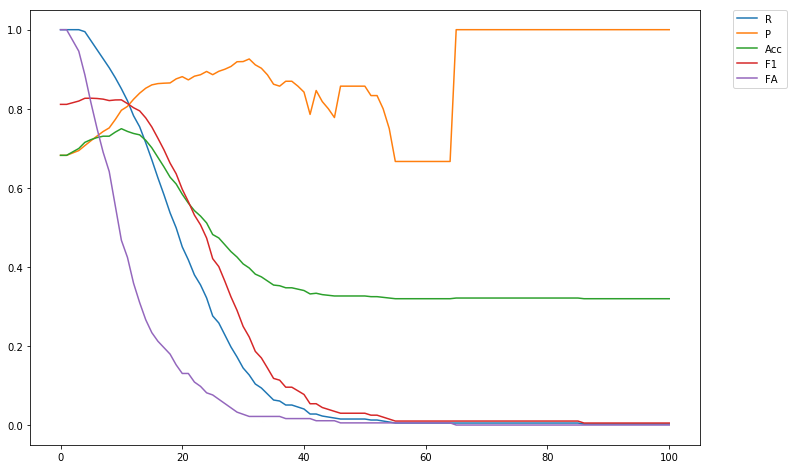

0.10000000000000001

In [98]:
threshold = find_threshold(label, energy)
threshold